The traditional go-to tool for causal inference is multiple regression:
$$
Y_i = \delta D_i + X_i'\beta+\varepsilon_i,
$$
where $D_i$ is the "treatment" or causal variable whose effects we are interested in, and $X_i$ is a vector of controls, conditional on which we are willing to assume $D_i$ is as good as randomly assigned.


> *example:* Suppose we are interested in the magnitude of racial discrimination in the labor market. One way to conceptualize this is the difference in earnings between two workers who are identical in productivity, but differ in their race, or, the "effect" of race. Then $D_i$ would be an indicator for, say, a Black worker. $Y_i$ would be earnings, and $X_i$ would be characteristics that capture determinants of productivity, including educational attainment, cognitive ability, and other background characteristics.

Where does machine learning fit into causal inference? It might be tempting to treat
this regression as a prediction exercise where we are predicting $Y_{i}$
given $D_{i}$ and $X_{i}$. Don't give in to this temptation. We are not
after a prediction for $Y_{i}$, we are after a coefficient on $D_{i}$.
Modern machine learning algorithms are finely tuned for producing
predictions, but along the way they compromise coefficients. So how can we
deploy machine learning in the service of estimating the causal coefficient $\delta $?

To see where ML fits in, first remember that an equivalent way to estimate $%
\delta $ is the following three-step procedure:


1.   Regress $Y_{i}$ on $X_{i}$ and compute the residuals, $\tilde{Y}%
_{i}=Y_{i}-\hat{Y}_{i}^{OLS}$, where $\hat{Y}_{i}^{OLS}=X_{i}^{\prime
}\left( X^{\prime }X\right) ^{-1}X^{\prime }Y$
2.   Regress $D_{i}$ on $X_{i}$ and compute the residuals, $\tilde{D}%
_{i}=D_{i}-\hat{D}_{i}^{OLS}$, where $\hat{D}_{i}^{OLS}=X_{i}^{\prime
}\left( X^{\prime }X\right) ^{-1}X^{\prime }D$

3. Regress $\tilde{Y}_{i}$ on $\tilde{D}_{i}$.

Steps 1 and 2 are prediction exercises--ML's wheelhouse. When OLS isn't the right tool for the job, we can replace OLS in those steps with machine learning:

1.   Predict $Y_{i}$ based on $X_{i}$ using ML and compute the residuals, $\tilde{Y}%
_{i}=Y_{i}-\hat{Y}_{i}^{ML}$, where $\hat{Y}_{i}^{ML}$ is the prediction from an ML algorithm
2.   Predict $D_{i}$ based on $X_{i}$ using ML and compute the residuals, $\tilde{D}%
_{i}=D_{i}-\hat{D}_{i}^{ML}$, where $\hat{D}_{i}^{ML}$ is the prediction from an ML algorithm

3. Regress $\tilde{Y}_{i}$ on $\tilde{D}_{i}$.

This is the basis for the two major methods we'll look at today: The first is "Post-Double Selection Lasso" (Belloni, Chernozhukov, Hansen). The second is "Double-Debiased Machine Learning" (Chernozhukov, Chetverikov, Demirer, Duflo, Hansen, Newey, Robins)

Outcome to be predicted:  Yi 

example: a worker's log wage

Characteristics (aka features):  Xi=(X1i,…,Xpi)′ 

example: education, age, state of birth, parents' education, cognitive ability, family background

NLSY: National Longitudinal Survey of Youth are a set of surveys designed to gather information at multiple points in time on the labor market activities and other significant life events of several groups of men and women.

In [2]:
%matplotlib inline

# import some useful packages
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split


plt.style.use('seaborn-whitegrid')

# read in data
nlsy=pd.read_csv('https://github.com/Mixtape-Sessions/Machine-Learning/blob/main/Labs/data/nlsy97.csv?raw=true')
nlsy

,lnw_2016,educ,black,hispanic,other,exp,afqt,mom_educ,dad_educ,yhea_100_1997,...,_XPexp_13,_XPexp_14,_XPexp_16,_XPexp_17,_XPexp_18,_XPexp_19,_XPexp_20,_XPexp_21,_XPexp_22,_XPexp_23
0,4.076898,16,0,0,0,11,7.0724,12,12,3,...,0,0,0,0,0,0,0,0,0,0
1,3.294138,9,0,0,0,19,4.7481,9,10,2,...,0,0,0,0,0,1,0,0,0,0
2,2.830896,9,0,1,0,22,1.1987,12,9,3,...,0,0,0,0,0,0,0,0,1,0
3,4.306459,16,0,0,0,13,8.9321,16,18,2,...,1,0,0,0,0,0,0,0,0,0
4,5.991465,16,0,1,0,15,2.2618,16,16,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,1.833475,14,1,0,0,17,3.8179,15,12,2,...,0,0,0,1,0,0,0,0,0,0
1262,3.341985,9,0,1,0,20,3.3043,12,11,2,...,0,0,0,0,0,0,1,0,0,0
1263,-0.928125,10,1,0,0,19,1.0319,10,13,2,...,0,0,0,0,0,1,0,0,0,0
1264,3.702931,18,0,0,0,12,8.5093,16,19,2,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# generate dictionary of transformations of education
powerlist=[nlsy['educ']**j for j in np.arange(1,10)]
X=pd.concat(powerlist,axis=1)
X.columns = ['educ'+str(j) for j in np.arange(1,10)]
# standardize our X matrix (doesn't matter for OLS, but will matter for lasso below)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# run least squares regression
# instantiate and fite our regression object:
reg=linear_model.LinearRegression().fit(X_scaled,nlsy['lnw_2016'])
# generate predicted values
yhat=reg.predict(X_scaled)

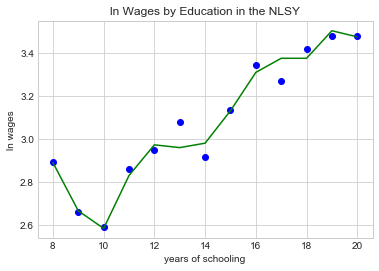

In [4]:
# plot predicted values
lnwbar=nlsy.groupby('educ')['lnw_2016'].mean()
Xbar=pd.DataFrame({'educ':lnwbar.index.values})
powerlist=[Xbar['educ']**j for j in np.arange(1,10)]
Xbar=pd.concat(powerlist,axis=1)
Xbar.columns = X.columns
Xbar_scaled = scaler.transform(Xbar)
ybarhat=reg.predict(Xbar_scaled)
fig = plt.figure()
ax = plt.axes()
ax.plot(Xbar['educ1'],lnwbar,'bo',Xbar['educ1'],ybarhat,'g-');
plt.title("ln Wages by Education in the NLSY")
plt.xlabel("years of schooling")
plt.ylabel("ln wages");

In [5]:
# fit lasso with a couple of different alphas and plot results
# instantiate and fite our lasso object
lasso1 = linear_model.Lasso(alpha=.001,max_iter=1000).fit(X_scaled,nlsy['lnw_2016'])
#generate predicted values
ybarhat1=lasso1.predict(Xbar_scaled)

# same thing but with a different alpha
lasso2 = linear_model.Lasso(alpha=.01,max_iter=1000).fit(X_scaled,nlsy['lnw_2016'])
ybarhat2=lasso2.predict(Xbar_scaled)

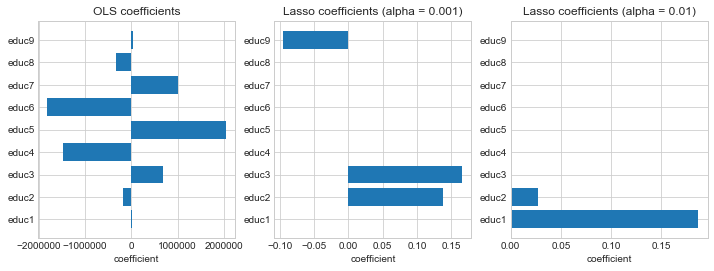

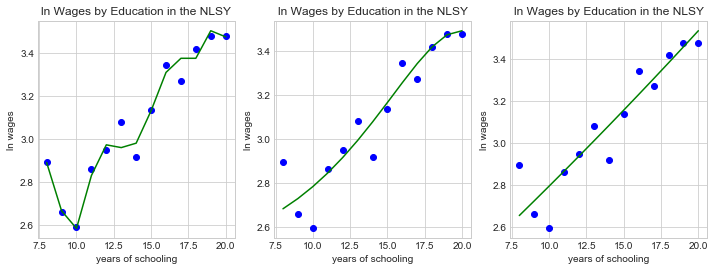

In [6]:
#@title
fig1,(ax11,ax12,ax13) = plt.subplots(1,3,figsize=(12, 4))
ax11.barh(Xbar.columns,reg.coef_,align='center');
ax11.set_title("OLS coefficients")
ax11.set_xlabel("coefficient")
ax12.barh(Xbar.columns,lasso1.coef_,align='center');
ax12.set_title("Lasso coefficients (alpha = {:.3f})".format(lasso1.get_params()['alpha']))
ax12.set_xlabel("coefficient")
ax13.barh(Xbar.columns,lasso2.coef_,align='center');
ax13.set_title("Lasso coefficients (alpha = {:.2f})".format(lasso2.get_params()['alpha']))
ax13.set_xlabel("coefficient")
fig2,(ax21,ax22,ax23) = plt.subplots(1,3,figsize=(12,4))
ax21.plot(Xbar['educ1'],lnwbar,'bo',Xbar['educ1'],ybarhat,'g-');
ax21.set_title("ln Wages by Education in the NLSY")
ax21.set_xlabel("years of schooling")
ax21.set_ylabel("ln wages");
ax22.plot(Xbar['educ1'],lnwbar,'bo',Xbar['educ1'],ybarhat1,'g-');
ax22.set_title("ln Wages by Education in the NLSY")
ax22.set_xlabel("years of schooling")
ax22.set_ylabel("ln wages");
ax23.plot(Xbar['educ1'],lnwbar,'bo',Xbar['educ1'],ybarhat2,'g-');
ax23.set_title("ln Wages by Education in the NLSY")
ax23.set_xlabel("years of schooling")
ax23.set_ylabel("ln wages");

Lasso-guided variable selection
For illustrative purposes we've been using lasso to determine the functional form for a single underlying regressor: education. But lasso's real power comes in selecting among a large number of regressors.

In [7]:
# Define "menu" of regressors:
X=nlsy.drop(columns=['lnw_2016','exp'])

# Divide into training and test set so we can honestly gauge predictive accuracy
X_train, X_test, y_train, y_test = train_test_split(X, nlsy['lnw_2016'],random_state=42)
# Scale regressors
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Do cross-validated Lasso (the easy way!)
# instantiate and fit our lassocv object
lassocv=linear_model.LassoCV(random_state=42).fit(X_train_scaled,y_train)
# print out the chosen value for alpha
print("Chosen alpha: {:.3f}".format(lassocv.alpha_))
# print the original number of regressors and the number selected by lasso
print("Number of regressors in the menu: ",len(X.columns))
print("Number of regressors selected by lasso: ",sum(lassocv.coef_!=0))
# print out accuracy on training and test test
print("Accuracy on training set: {:.3f}".format(lassocv.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(lassocv.score(X_test_scaled,y_test)))
# look at the coefficients
results = pd.DataFrame({'feature': X.columns[lassocv.coef_!=0],'coefficient': lassocv.coef_[lassocv.coef_!=0]})
results

Chosen alpha: 0.045
Number of regressors in the menu:  992
Number of regressors selected by lasso:  59
Accuracy on training set: 0.249
Accuracy on test set: 0.103


,feature,coefficient
0,educ,0.094004
1,black,-0.062092
2,hispanic,0.012279
3,afqt,0.072048
4,ysaq_284_1997,0.029376
5,youth_bothbio_01_1997,0.015209
6,p4_001_1997,-0.031068
7,cv_yth_rel_hh_age_2_1997,-0.007405
8,fp_adpenvri_1997,-0.002718
9,cvc_govnt_prg_yr_94_xrnd,-0.000061


Ridge Regression with the same data ( Ridge is another flavor of penalized regression, like lasso. But unlike lasso, ridge penalizes the squares (not the absolute values) of the coefficients. As a result, ridge shrinks coefficients toward zero, but not all the way. Let's give it a try.)

In [8]:
ridgecv=linear_model.RidgeCV(cv=5,alphas=(.1,1,10,50,100,1000)).fit(X_train_scaled,y_train)
print("Chosen alpha: {:.3f}".format(ridgecv.alpha_))
print("Accuracy on training set: {:.3f}".format(ridgecv.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(ridgecv.score(X_test_scaled,y_test)))
# look at the coefficients
results = pd.DataFrame({'feature': X.columns[ridgecv.coef_!=0],'coefficient': ridgecv.coef_[ridgecv.coef_!=0]})
results

Chosen alpha: 1000.000
Accuracy on training set: 0.486
Accuracy on test set: -0.048


,feature,coefficient
0,educ,0.038142
1,black,-0.031903
2,hispanic,0.031672
3,other,-0.013500
4,afqt,0.038021
...,...,...
907,_XPexp_19,-0.021927
908,_XPexp_20,-0.014198
909,_XPexp_21,0.002014
910,_XPexp_22,-0.011529


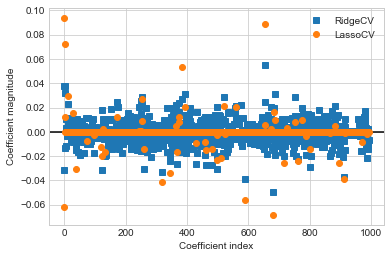

In [9]:
plt.plot(ridgecv.coef_, 's', label="RidgeCV")
plt.plot(lassocv.coef_, 'o', label="LassoCV")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.legend()

Elastic Net: Best of Both Worlds!

In [10]:
encv=linear_model.ElasticNetCV(random_state=42,l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(X_train_scaled,y_train)
print("Chosen l1 ratio: {:.3f}".format(encv.l1_ratio_))
print("Chosen alpha: {:.3f}".format(encv.alpha_))
print("Number of regressors in the menu: ",len(X.columns))
print("Number of regressors selected by elastic net: ",sum(encv.coef_!=0))
print("Accuracy on training set: {:.3f}".format(encv.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(encv.score(X_test_scaled,y_test)))
# look at the coefficients
results = pd.DataFrame({'feature': X.columns[encv.coef_!=0],'coefficient': encv.coef_[encv.coef_!=0]})
results

Chosen l1 ratio: 0.500
Chosen alpha: 0.090
Number of regressors in the menu:  992
Number of regressors selected by elastic net:  70
Accuracy on training set: 0.245
Accuracy on test set: 0.102


,feature,coefficient
0,educ,0.088755
1,black,-0.059167
2,hispanic,0.010870
3,afqt,0.071367
4,dad_educ,0.000199
...,...,...
65,_BGhfp_adpe_7,-0.022920
66,_BGhp5_102__3,-0.037543
67,_BGhp5_102__7,-0.000845
68,_BGhcvc_govq4,-0.007933


EXTRA: Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

# First without cross-validating
rf=RandomForestRegressor(random_state=42).fit(X_train,y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test,y_test)))

Accuracy on training set: 0.874
Accuracy on test set: 0.100
